#  Cheapest day before a flight to buy tickets prediction - Iteration 0

In [53]:
import sklearn
import pandas as pd
import seaborn
from types import SimpleNamespace

iterations = SimpleNamespace(
    zero=SimpleNamespace(),
    one=SimpleNamespace()
)

# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** and **EIN-SOF**. The dataset includes data from **02.2025 - 12.2025**

In [54]:
data1 = pd.read_csv('./datasets/iteration0/flight_prices_SOF_EIN.csv', parse_dates=["departureDate"])
data2 = pd.read_csv('./datasets/iteration0/flight_prices_EIN_SOF.csv', parse_dates=["departureDate"])

iterations.zero.main_data = pd.concat([data1, data2])

# 📃 Sample the data


In [55]:
iterations.zero.main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday
4950,143,2025-05-30,57,Sofia,Eindhoven,False,False
15782,304,2025-12-11,95,Sofia,Eindhoven,False,False
1906,81,2025-04-04,80,Eindhoven,Sofia,False,False
11924,238,2025-09-22,64,Sofia,Eindhoven,True,False
16857,336,2025-12-21,215,Eindhoven,Sofia,False,True
12237,228,2025-09-20,90,Eindhoven,Sofia,False,False
3295,118,2025-04-27,72,Eindhoven,Sofia,False,True
8253,188,2025-07-23,57,Sofia,Eindhoven,False,True
8524,165,2025-07-27,109,Sofia,Eindhoven,False,True
12928,219,2025-10-01,57,Eindhoven,Sofia,False,False


In [56]:
group_info = iterations.zero.main_data.groupby(["departure_airport"])["departure_airport"].count()
group_info

departure_airport
Eindhoven    16958
Sofia        16288
Name: departure_airport, dtype: int64

# 🛠️ Preprocessing 

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the days before a flight, containing the cheapest tickets. 

## 🎯 Target Variable


First, as the algorhitm is categorical, we need to convert the target variable into a category.

In [57]:
category_order = ['days < 7', '7 <= days < 14', '13 <= days < 30', '30 <= days < 60', '60 <= days < 100', ' 100 <= days >= 200', 'days > 200']

def categorize_daysAgo(days): # from 0 to 300
    if days < 7:
        return category_order[0]
    elif 7 <= days < 14:
        return category_order[1]
    elif 14 <= days < 30:
        return category_order[2]
    elif 30 <= days < 60:
        return category_order[3]
    elif 60 <= days < 100:
        return category_order[4]
    elif 100 <= days < 200:
        return category_order[5]
    else:
        return category_order[6]

iterations.zero.main_data["daysAgo_category"] = iterations.zero.main_data["daysAgo"].apply(categorize_daysAgo)
iterations.zero.main_data['daysAgo_category'] = pd.Categorical(iterations.zero.main_data['daysAgo_category'], categories=category_order, ordered=True)



Then, we need to convert the respectable non numerical values (airports and holidays) into numberical values

In [58]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
iterations.zero.main_data["daysAgo_category_id"] = encoder.fit_transform(iterations.zero.main_data["daysAgo_category"])

iterations.zero.main_data["departure_airport_id"] = encoder.fit_transform(iterations.zero.main_data["departure_airport"])
iterations.zero.main_data["arrival_airport_id"] = encoder.fit_transform(iterations.zero.main_data["arrival_airport"])

iterations.zero.main_data["is_public_holiday"] = iterations.zero.main_data["is_public_holiday"].astype(int)
iterations.zero.main_data["is_school_holiday"] = iterations.zero.main_data["is_school_holiday"].astype(int)

iterations.zero.main_data.drop(["departure_airport", "arrival_airport"], axis=1, inplace=True)

iterations.zero.main_data.sample(10)


,daysAgo,departureDate,price,is_public_holiday,is_school_holiday,daysAgo_category,daysAgo_category_id,departure_airport_id,arrival_airport_id
14037,288,2025-10-20,57,0,1,days > 200,6,0,1
13638,262,2025-10-22,64,0,1,days > 200,6,1,0
11342,193,2025-09-05,72,0,0,100 <= days >= 200,0,0,1
1343,86,2025-03-26,40,0,0,60 <= days < 100,3,0,1
10962,207,2025-09-05,96,0,0,days > 200,6,1,0
4006,95,2025-05-14,41,0,0,60 <= days < 100,3,1,0
8605,208,2025-07-29,64,0,1,days > 200,6,1,0
8505,184,2025-07-27,81,0,1,100 <= days >= 200,0,1,0
4942,151,2025-05-30,57,0,0,100 <= days >= 200,0,1,0
5147,132,2025-06-02,64,0,0,100 <= days >= 200,0,1,0


In [59]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import parallel_coordinates

Now we will create several graphs to visualize relationships between the values of the dataset

/var/folders/y7/db2_95bs6k9djjfg92g5zmnr0000gn/T/ipykernel_7877/173764071.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_range = iterations.zero.main_data.groupby('daysAgo_category')['price'].mean().reset_index()


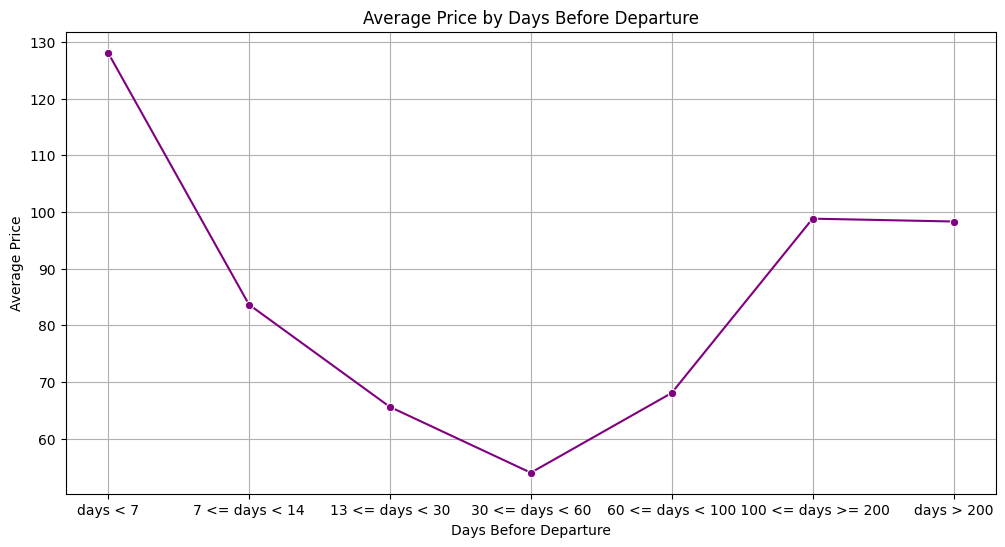

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

avg_price_by_range = iterations.zero.main_data.groupby('daysAgo_category')['price'].mean().reset_index()

# Sort the DataFrame by 'daysAgo_category' to ensure the plot uses the correct order
avg_price_by_range = avg_price_by_range.sort_values('daysAgo_category', ascending=True)

# Plotting average price by days range
plt.figure(figsize=(12,6))
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range, marker='o', color='purple')

# Adding labels and title
plt.title('Average Price by Days Before Departure')
plt.xlabel('Days Before Departure')
plt.ylabel('Average Price')

# Add grid to the plot
plt.grid(True)

# Show plot
plt.show()

The graph clearly shows that the **best time to buy** a ticket is **between 30 and 60 days before departure**, with prices peaking when tickets are booked much earlier or very close to the departure date.

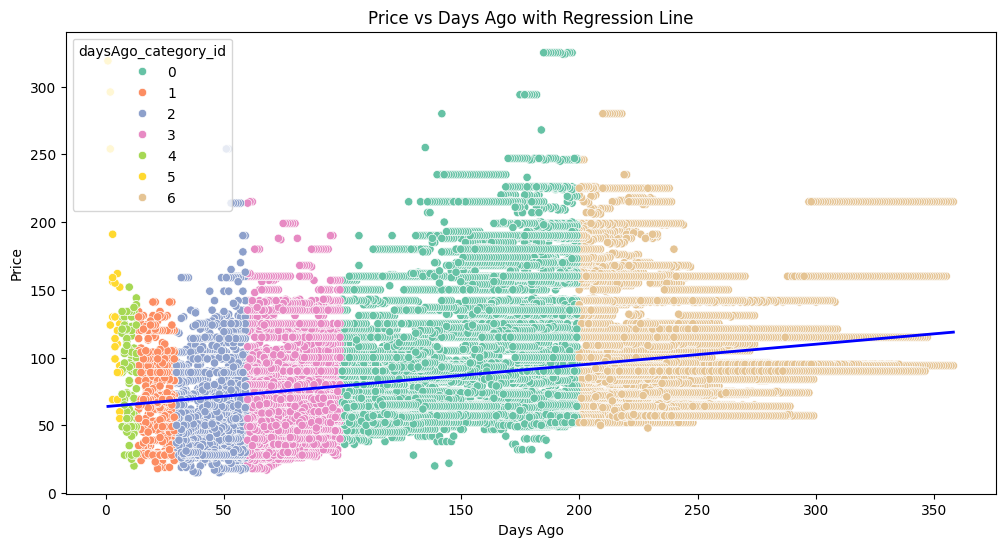

In [61]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='daysAgo', y='price', data=iterations.zero.main_data, hue='daysAgo_category_id', palette='Set2')
sns.regplot(x='daysAgo', y='price', data=iterations.zero.main_data, scatter=False, color='blue', line_kws={'linewidth': 2})
plt.title('Price vs Days Ago with Regression Line')
plt.xlabel('Days Ago')
plt.ylabel('Price')
plt.show()

This graph indicates that the number of days before departure (daysAgo) has a positive correlation with price, meaning that as flights are booked earlier, their prices tend to rise. This could be due to factors like demand for early bookings or promotions on last-minute deals. However, there is still a significant amount of variation in the price for each category, suggesting that other factors (like seasonality, holidays, etc.) could also be influencing ticket prices.

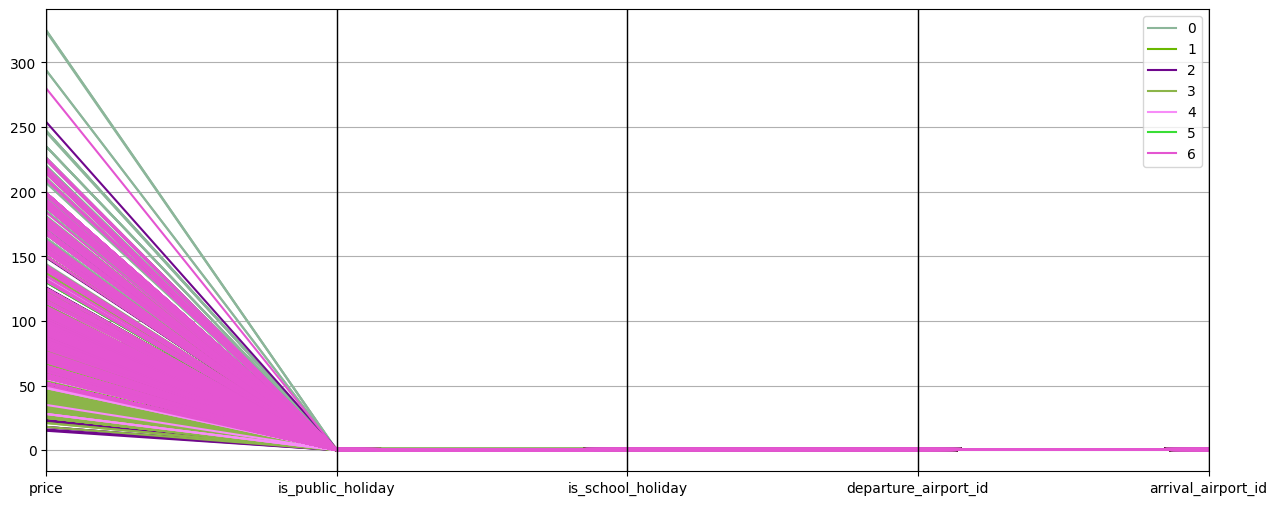

In [62]:
# Define numeric columns
numeric_candidates = ['price', 'is_public_holiday', 'is_school_holiday', 'departure_airport_id', 'arrival_airport_id', 'daysAgo_category_id']

# Plot the parallel coordinates with the encoded values
fig = plt.figure(figsize=[15,6])

ax = parallel_coordinates(iterations.zero.main_data[numeric_candidates].sample(5000).sort_values(by="daysAgo_category_id"), 
                          class_column='daysAgo_category_id')

plt.show()

From the parallel coordinates plot, here are the key observations we can conclude:
- Price variation is significant across the ``daysAgo_category_id`` categories, with some categories showing higher prices, especially as the number of days before departure increases.
- Features like *holidays* a d *airports*, and seem to have minimal effect on price in this case, and the main factor influencing price appears to be the number of days before departure (captured by ``daysAgo_category_id``).

### 💡 Feature Selection


To optimize our model, we must select only those features that best explain the variance in the target variable—the number of days before departure when the ticket is cheapest. Since flight prices fluctuate due to multiple factors, we will focus on features that exhibit distinguishable patterns across different days. Our dataset includes variables such as ``` departureDate, daysAgo, departure_airport, arrival_airport, and holiday indicators (is_public_holiday, is_school_holiday).```

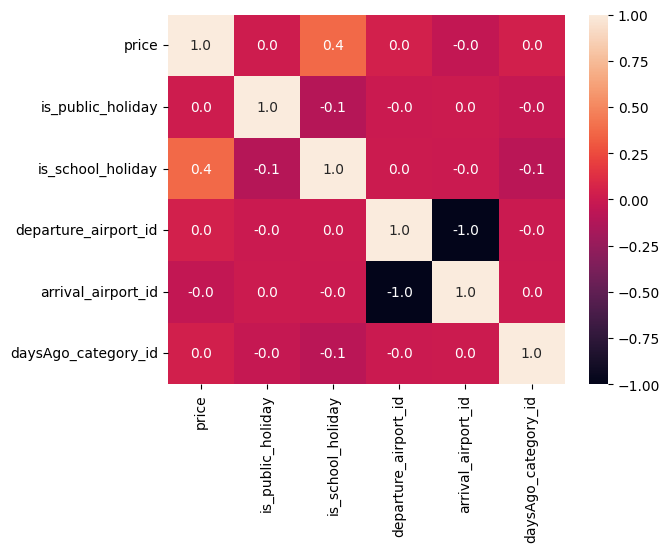

In [63]:
correlations = iterations.zero.main_data[numeric_candidates].corr()
plot = seaborn.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

Conclusion:
- **Strong Factors**: ``is_school_holiday`` moderately influences price, while other features like `departure_airport_id` and `arrival_airport_id` seem to have little or no impact.
- **Weak/No Correlations**: Public holidays have *minimal impact* on ticket prices in this dataset, suggesting these features are *less important* for optimizing the model in terms of price prediction.

In [64]:
# Define the target and parameters
target = 'daysAgo_category_id'
params = ['price', 'is_public_holiday', 'is_school_holiday', 'departure_airport_id', 'arrival_airport_id', 'daysAgo']

X = iterations.zero.main_data[params]
y = iterations.zero.main_data[target]
# maybe try without public holidays

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")
X_train

There are in total 33246 observations, of which 26596 are now in the train set, and 6650 in the test set.


,price,is_public_holiday,is_school_holiday,departure_airport_id,arrival_airport_id,daysAgo
4211,52,0,0,0,1,132
6180,94,0,0,1,0,153
15850,94,0,0,1,0,298
12801,64,0,0,1,0,231
10069,90,0,1,0,1,226
...,...,...,...,...,...,...
14248,121,0,0,1,0,275
12292,93,0,0,0,1,235
16790,160,0,0,0,1,340
9318,199,0,1,1,0,177


# 🧬 Modelling

`k Nearest Neighbour` will be used at these first stages of the development

In [66]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the KNeighborsRegressor model
iterations.zero.knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
iterations.zero.knn.fit(X_train, y_train)

# Predict the target values on the test set
pred = iterations.zero.knn.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. This shows for every one of the classes how well the model performed.

In [67]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.031067669172932334
Root Mean Squared Error (RMSE): 0.23492119939420544
R² Score: 0.9922561433179072


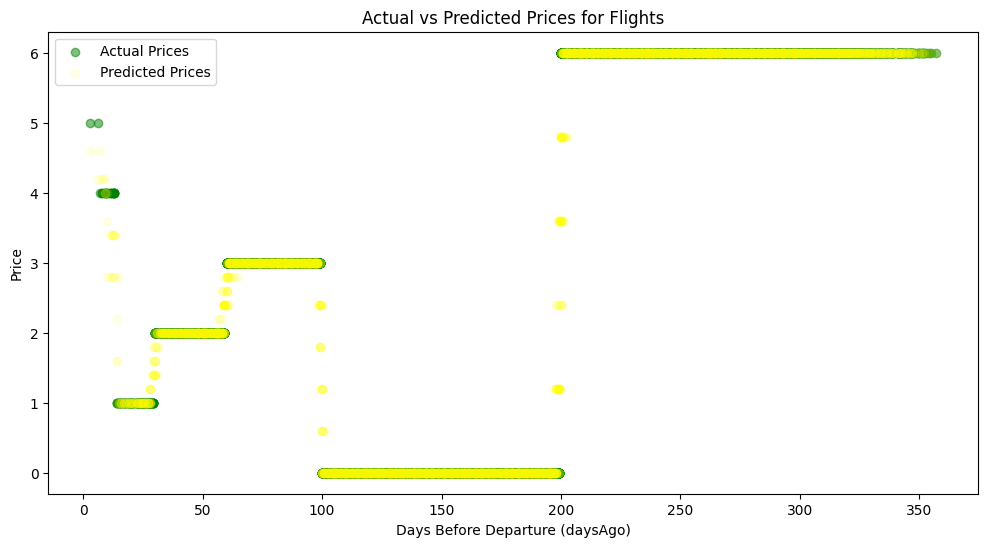

In [68]:
plt.figure(figsize=(12, 6))

# Scatter plot for actual prices
plt.scatter(X_test['daysAgo'], y_test, color='green', alpha=0.5, label='Actual Prices')

# Scatter plot for predicted prices
plt.scatter(X_test['daysAgo'], pred, color='yellow', alpha=0.1, label='Predicted Prices')

# Adding titles and labels
plt.title('Actual vs Predicted Prices for Flights')
plt.xlabel('Days Before Departure (daysAgo)')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

Based on this chart, we can conclude that the model seems to correctly predict when the tickets will be the cheapest, but has difficulti when the actual value is close to the "edge" of the category and overlaps with another category.

---------------

# Cheapest day before a flight to buy tickets prediction - Iteration 1

In [69]:
import sklearn
import pandas as pd
import seaborn
import numpy as np

# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** , **EIN-SOF** , **EIN-ATH** , **ISTANBUL-AMS** , **MUNICH - NEW YORK**. The dataset includes data from **03.2025 - 12.2025**

In [70]:
import glob

csv_files = glob.glob("./datasets/iteration1/*.csv")

iterations.one.main_data = pd.concat([pd.read_csv(file, parse_dates=["departureDate", "record_timestamp"], low_memory=False) for file in csv_files], ignore_index=True)


# 📃 Sample the data


In [71]:
iterations.one.main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp
57537,181,2025-08-30,44,New York,"Washington, D.C.",False,True,Republic American,1.0,2025-03-02
21744,219,2025-08-29,185,Sofia,Eindhoven,False,True,Other,-1.0,2025-01-22
50621,81,2025-05-07,44,New York,"Washington, D.C.",False,False,Republic American,1.0,2025-02-15
35409,223,2025-09-24,86,İstanbul,Amsterdam,False,False,Turkish Airlines,1.0,2025-02-13
43685,135,2025-07-24,190,Eindhoven,Sofia,False,True,Wizzair,1.0,2025-03-11
7919,139,2025-08-02,144,Eindhoven,Athens,False,True,Transavia,0.0,2025-03-16
23161,228,2025-09-21,81,Sofia,Eindhoven,False,False,Wizzair,-1.0,2025-02-05
27813,83,2025-05-24,94,İstanbul,Amsterdam,True,False,Turkish Airlines,0.0,2025-03-02
59637,251,2025-10-04,56,New York,"Washington, D.C.",False,False,Delta,-1.0,2025-01-26
55406,132,2025-07-24,60,New York,"Washington, D.C.",False,True,Delta,1.0,2025-03-14


In [72]:
group_info = iterations.one.main_data.groupby(["departure_airport"])["departure_airport"].count()
group_info

departure_airport
Eindhoven    23845
New York     11848
Sofia        11987
İstanbul     12316
Name: departure_airport, dtype: int64

# 🛠️ Preprocessing 

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the days before a flight, containing the cheapest tickets. 

## 🎯 Target Variable


First, as the algorhitm is categorical, we need to convert the target variable into a category.

In [73]:
import pandas as pd
import numpy as np
import math

# Define bin edges and corresponding category labels
bins = [7, 14, 30, 60, 100, 200]  # Upper limits for each category
category_order = [
    'days < 7', '7 <= days < 14', '14 <= days < 30',
    '30 <= days < 60', '60 <= days < 100', '100 <= days < 200', 'days > 200'
]

# Assign categories based on bin indices
indices = np.digitize(iterations.one.main_data["daysAgo"], bins, right=False)
iterations.one.main_data["daysAgo_category"] = np.array(category_order)[indices]

# Convert to categorical with the specified order
iterations.one.main_data['daysAgo_category'] = pd.Categorical(iterations.one.main_data['daysAgo_category'], categories=category_order, ordered=True)

## Addming new feature - distance between departure and arrival airports

In [74]:
airport_coords = {
    'New York': (40.7128, -74.0060),
    'Amsterdam': (52.3676, 4.9041),
    'Athens': (37.9838, 23.7275),
    'Eindhoven': (51.4416, 5.4697),
    'Sofia': (42.6975, 23.3242),
    'Washington, D.C.': (38.8951, -77.0364),
    'İstanbul': (41.0082, 28.9784)
}

# Function to calculate Haversine distance
# Source: https://stackoverflow.com/questions/25711895/the-result-by-haversine-formula-is-meter-o-kmeter
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in km

# Function to calculate distance for each row in DataFrame
def calculate_distance(row):
    dep = row['departure_airport']
    arr = row['arrival_airport']
    if dep in airport_coords and arr in airport_coords:
        lat1, lon1 = airport_coords[dep]
        lat2, lon2 = airport_coords[arr]
        return haversine_distance(lat1, lon1, lat2, lon2)
    else:
        return None  # Handle missing airport coordinates

# Apply the function to compute distances in your existing dataset
iterations.one.main_data['airport_distance_km'] = iterations.one.main_data.apply(calculate_distance, axis=1)
iterations.one.main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp,daysAgo_category,airport_distance_km
57175,171,2025-08-24,52,New York,"Washington, D.C.",False,True,Republic American,-1.0,2025-03-06,100 <= days < 200,328.393017
39604,62,2025-05-18,74,Eindhoven,Sofia,False,False,Ryanair,-1.0,2025-03-17,60 <= days < 100,1658.335311
22689,204,2025-09-13,121,Sofia,Eindhoven,False,False,Wizzair,1.0,2025-02-21,days > 200,1658.335311
4389,78,2025-06-04,152,Eindhoven,Athens,False,False,Transavia,NaN,2025-03-18,60 <= days < 100,2067.423123
9386,160,2025-08-26,59,Eindhoven,Athens,False,True,Transavia,1.0,2025-03-19,100 <= days < 200,2067.423123
31738,179,2025-07-27,112,İstanbul,Amsterdam,False,True,Turkish Airlines,-1.0,2025-01-29,100 <= days < 200,2211.947562
6706,173,2025-07-13,151,Eindhoven,Athens,False,True,Transavia,1.0,2025-01-21,100 <= days < 200,2067.423123
39737,115,2025-05-21,50,Eindhoven,Sofia,False,False,Ryanair,-1.0,2025-01-26,100 <= days < 200,1658.335311
45624,180,2025-08-25,50,Eindhoven,Sofia,False,True,Ryanair,-1.0,2025-02-26,100 <= days < 200,1658.335311
39938,100,2025-05-24,90,Eindhoven,Sofia,True,False,Wizzair,0.0,2025-02-13,100 <= days < 200,1658.335311


Then, we need to convert the respectable non numerical values (airports and holidays) into numberical values

Why One-Hot Encoding the Airline Might Be Better:
	1.	Lower Correlation with Other Features – The airline feature does not show strong linear correlations with other features, which suggests that it might not introduce significant redundancy when one-hot encoded.
	2.	Categorical Nature of Airlines – Airlines are naturally categorical and one-hot encoding could help preserve distinct airline identities without introducing ordinal relationships that don’t exist.
	3.	Potential Interactions – Different airlines may have distinct pricing strategies that one-hot encoding can help capture.

Why Keeping Departure/Arrival Airports as Label Encoded Might Be Better:
	1.	Strong Correlation Between Airports – Departure and arrival airports show higher correlations among themselves. This might indicate that the distance between airports (which you could introduce as a feature) could be a more meaningful numerical representation.
	2.	High-Dimensionality Risk – One-hot encoding airports can significantly increase the number of features, especially if there are many unique airports. This could make training less efficient and introduce sparsity issues

In [75]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
iterations.one.main_data["daysAgo_category_id"] = encoder.fit_transform(iterations.one.main_data["daysAgo_category"])
iterations.one.main_data.drop(columns=['daysAgo_category'], inplace=True)
iterations.one.main_data.drop(columns=['daysAgo'], inplace=True)

# Perform one-hot encoding on 'airline' and label encoding on airports
iterations.one.main_data = pd.get_dummies(iterations.one.main_data, columns=['airline'])

cols_to_convert = iterations.one.main_data.columns[-9:]  # Select the last 9 columns, which are one-hot encoded
iterations.one.main_data[cols_to_convert] = iterations.one.main_data[cols_to_convert].astype(int)  # Convert True/False to 0/1

iterations.one.main_data['departure_date_unix'] = iterations.one.main_data['departureDate'].astype('int64') // 10**9
iterations.one.main_data['record_timestamp_unix'] = iterations.one.main_data['record_timestamp'].astype('int64') // 10**9
iterations.one.main_data = pd.get_dummies(iterations.one.main_data, columns=['near_holiday']) # as the columns is -1, 0, 1 which messes with the algorithm

iterations.one.main_data["departure_airport"] = encoder.fit_transform(iterations.one.main_data["departure_airport"])
iterations.one.main_data["arrival_airport"] = encoder.fit_transform(iterations.one.main_data["arrival_airport"])

#removing these columns as the  "near_holiday" has the same purpose

iterations.one.main_data.drop(columns=['is_public_holiday'], inplace=True)
iterations.one.main_data.drop(columns=['is_school_holiday'], inplace=True)

#removing these colums as they are converted to unix
iterations.one.main_data.drop(columns=['departureDate'], inplace=True)
iterations.one.main_data.drop(columns=['record_timestamp'], inplace=True)


col = iterations.one.main_data.pop("daysAgo_category_id")  # Remove the column
iterations.one.main_data.insert(0, "daysAgo_category_id", col)  # Insert it at 0

iterations.one.main_data.sample(10)

,daysAgo_category_id,price,departure_airport,arrival_airport,airport_distance_km,airline_Aegean,airline_Delta,airline_Other,airline_Pegasus,airline_Republic American,airline_Ryanair,airline_Transavia,airline_Turkish Airlines,airline_Wizzair,departure_date_unix,record_timestamp_unix,near_holiday_-1.0,near_holiday_0.0,near_holiday_1.0
23270,6,74,2,2,1658.335311,0,0,0,0,0,1,0,0,0,1758585600,1737590400,False,False,True
49644,3,182,1,4,328.393017,0,1,0,0,0,0,0,0,0,1745107200,1739491200,True,False,False
6611,0,185,0,1,2067.423123,0,0,1,0,0,0,0,0,0,1752192000,1739750400,False,False,True
26248,3,104,3,0,2211.947562,0,0,0,0,0,0,0,1,0,1745884800,1739404800,True,False,False
18525,0,52,2,2,1658.335311,0,0,0,0,0,0,0,0,1,1751846400,1738713600,False,True,False
50739,3,24,1,4,328.393017,0,0,0,0,1,0,0,0,0,1746748800,1739232000,False,False,True
7203,0,147,0,1,2067.423123,0,0,0,0,0,0,1,0,0,1753056000,1738195200,False,False,True
53398,3,68,1,4,328.393017,0,0,0,0,1,0,0,0,0,1750464000,1742342400,False,False,False
34274,6,130,3,0,2211.947562,0,0,0,0,0,0,0,1,0,1757116800,1737763200,False,True,False
17098,3,62,2,2,1658.335311,0,0,0,0,0,0,0,0,1,1749772800,1741910400,False,False,False


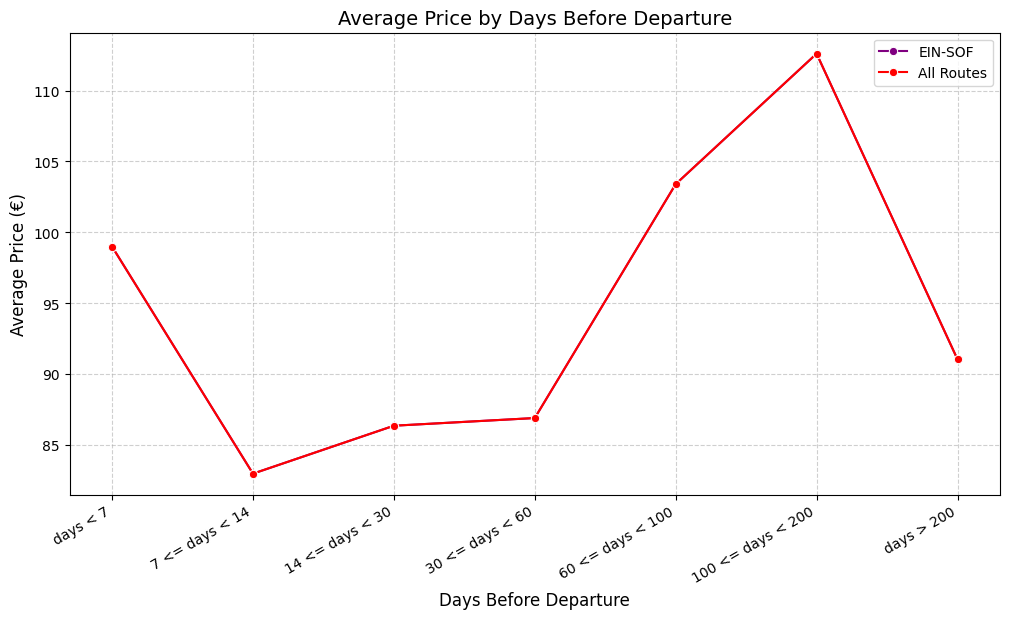

In [76]:
# Create a mapping from category_id to category name
category_mapping = {i: category_order[i] for i in range(len(category_order))}

# Function to process the data
def process_avg_price_by_category(df, category_id_column):
    # Group by 'daysAgo_category_id' and calculate mean price
    avg_price_by_range = df.groupby(category_id_column)['price'].mean().reset_index()

    # Map category ID to category name
    avg_price_by_range['daysAgo_category'] = avg_price_by_range[category_id_column].map(category_mapping)

    # Convert to categorical type with correct ordering
    avg_price_by_range['daysAgo_category'] = pd.Categorical(
        avg_price_by_range['daysAgo_category'], categories=category_order, ordered=True
    )

    # Sort data based on category order
    avg_price_by_range = avg_price_by_range.sort_values('daysAgo_category')

    return avg_price_by_range

# Process data for both datasets
avg_price_by_range_0 = process_avg_price_by_category(iterations.one.main_data, 'daysAgo_category_id')
avg_price_by_range_1 = process_avg_price_by_category(iterations.one.main_data, 'daysAgo_category_id')

# Plotting
plt.figure(figsize=(12,6))
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range_0, marker='o', color='purple', label='EIN-SOF')
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range_1, marker='o', color='red', label='All Routes')

# Labels and title
plt.title('Average Price by Days Before Departure', fontsize=14)
plt.xlabel('Days Before Departure', fontsize=12)
plt.ylabel('Average Price (€)', fontsize=12)

# Rotate x-axis labels properly
plt.xticks(rotation=30, ha='right')

# Add legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()

Conclusion:
- EIN-SOF has more extreme price fluctuations
	- The EIN-SOF route shows sharper drops and peaks compared to the overall trend.
	- Prices drop significantly for this route between 7-30 days before departure, reaching a much lower minimum than the general trend.
	- It also experiences a more dramatic peak beyond 100 days before departure, suggesting a stronger price hike compared to other routes.
- Overall trend (red line) is more stable
	-	The general trend for all routes follows a similar pattern but is smoother, without extreme dips or spikes.
	-	It suggests a more predictable pricing structure across multiple routes, whereas EIN-SOF might be influenced by specific demand fluctuations.

Now we will create several graphs to visualize relationships between the features of the dataset

### 💡 Feature Selection


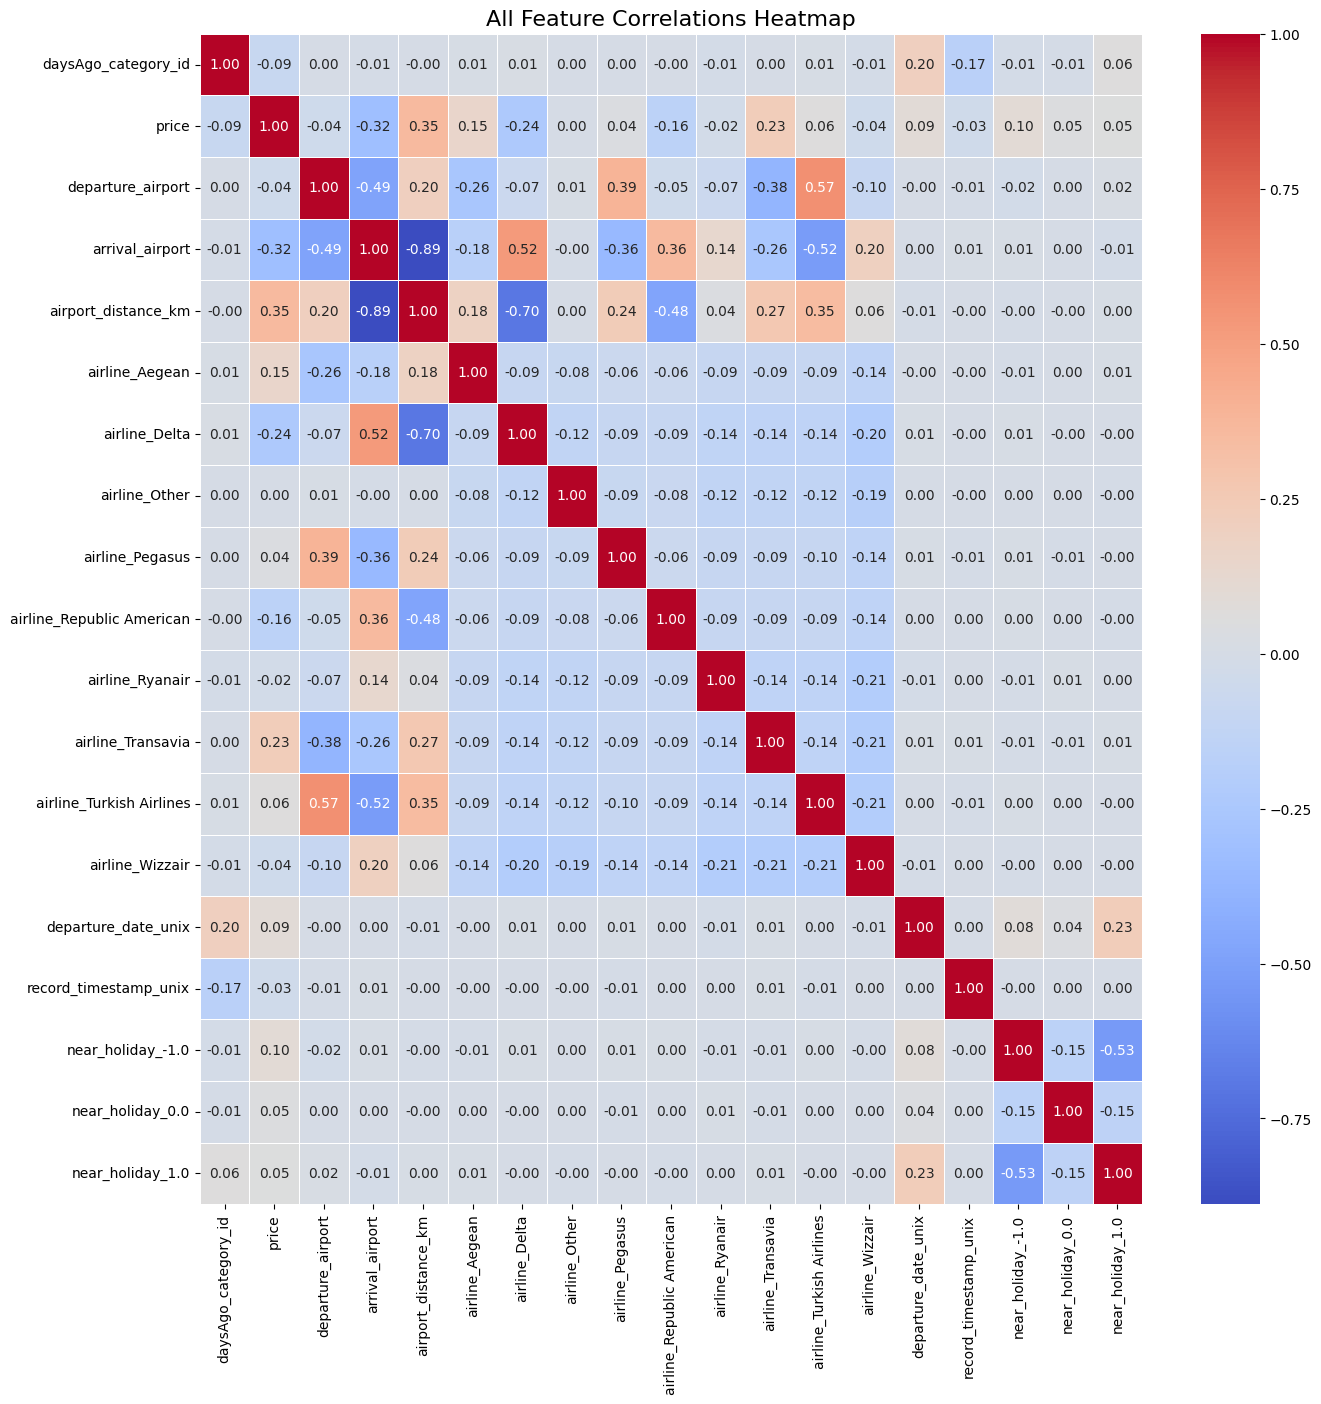

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = iterations.one.main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [78]:
correlation_target = iterations.one.main_data.corr()['daysAgo_category_id'].sort_values(ascending=False)
print(correlation_target)

daysAgo_category_id          1.000000
departure_date_unix          0.203784
near_holiday_1.0             0.057089
airline_Delta                0.011721
airline_Turkish Airlines     0.007222
airline_Aegean               0.005125
airline_Transavia            0.003665
airline_Pegasus              0.003416
departure_airport            0.003347
airline_Other                0.002389
airline_Republic American   -0.001264
airport_distance_km         -0.001932
arrival_airport             -0.006253
near_holiday_0.0            -0.006745
near_holiday_-1.0           -0.010950
airline_Ryanair             -0.011575
airline_Wizzair             -0.014237
price                       -0.087728
record_timestamp_unix       -0.167054
Name: daysAgo_category_id, dtype: float64


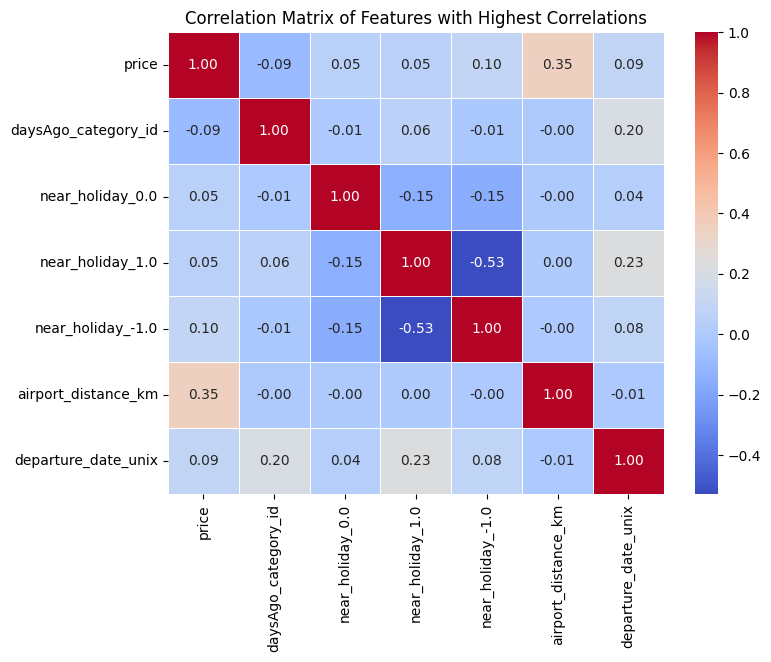

In [79]:
most_important_columns = ['price', 'daysAgo_category_id', 'near_holiday_0.0','near_holiday_1.0','near_holiday_-1.0', 'airport_distance_km', 'departure_date_unix']
correlation_matrix = iterations.one.main_data[most_important_columns].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features with Highest Correlations")
plt.show()

In [88]:
correlation_target = correlation_matrix['daysAgo_category_id'].sort_values(ascending=False)
print(correlation_target)

daysAgo_category_id    1.000000
departure_date_unix    0.203784
near_holiday_1.0       0.057089
airport_distance_km   -0.001932
near_holiday_0.0      -0.006745
near_holiday_-1.0     -0.010950
price                 -0.087728
Name: daysAgo_category_id, dtype: float64


We can conclude:
- Price vs. Airport Distance
    - The highest positive correlation is between price and airport_distance_km. This suggests that flights covering longer distances tend to have higher prices, which aligns with common expectations.
- 	Holidays are not a key factor: Despite common beliefs, near_holiday does not have a high correlation with price.

In [81]:
# Define the target and parameters
target = 'daysAgo_category_id'

X = iterations.one.main_data[most_important_columns]
y = iterations.one.main_data[target]

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

X_train

There are in total 59996 observations, of which 47996 are now in the train set, and 12000 in the test set.


,price,daysAgo_category_id,near_holiday_0.0,near_holiday_1.0,near_holiday_-1.0,airport_distance_km,departure_date_unix
27369,89,3,False,False,True,2211.947562,1747440000
5671,115,3,False,False,False,2067.423123,1750809600
33550,169,0,False,True,False,2211.947562,1756080000
12345,94,4,False,False,False,1658.335311,1742947200
5392,102,0,False,False,False,2067.423123,1750464000
...,...,...,...,...,...,...,...
48115,64,6,False,False,True,1658.335311,1759622400
11001,69,6,True,False,False,2067.423123,1758499200
8384,106,0,False,False,True,2067.423123,1754784000
40919,52,0,False,False,False,1658.335311,1749427200


# 🧬 Modelling

`k Nearest Neighbour` will be used at these first stages of the development

In [83]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the KNeighborsRegressor model
iterations.one.knn = KNeighborsClassifier()

# Fit the model on the training data
iterations.one.knn.fit(X_train, y_train)

# Predict the target values on the test set
pred = iterations.one.knn.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. This shows for every one of the classes how well the model performed.

In [84]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.13308333333333333
Root Mean Squared Error (RMSE): 0.6478811619425279
R² Score: 0.9139070752390218


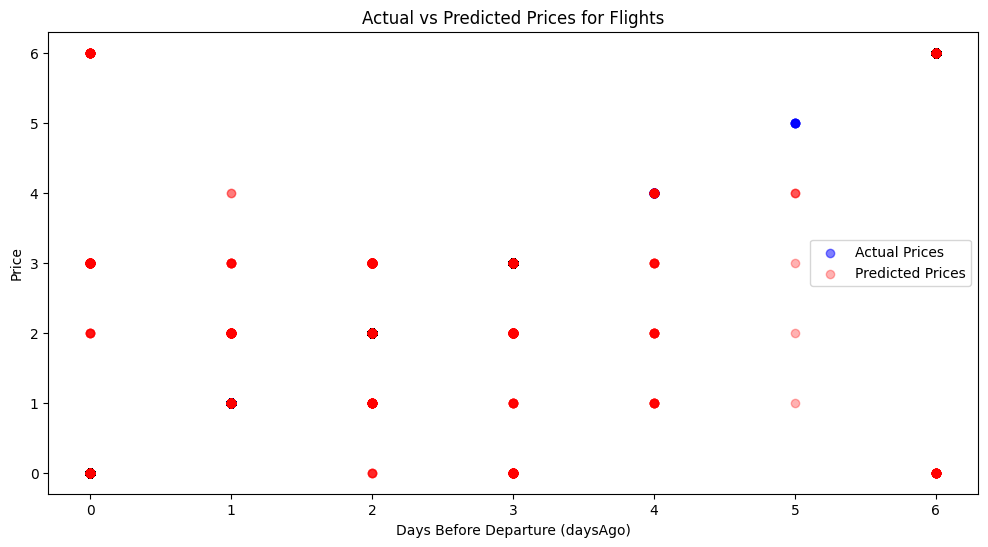

In [85]:
plt.figure(figsize=(12, 6))

# Scatter plot for actual prices
plt.scatter(X_test['daysAgo_category_id'], y_test, color='blue', alpha=0.5, label='Actual Prices')

# Scatter plot for predicted prices
plt.scatter(X_test['daysAgo_category_id'], pred, color='red', alpha=0.3, label='Predicted Prices')

# Adding titles and labels
plt.title('Actual vs Predicted Prices for Flights')
plt.xlabel('Days Before Departure (daysAgo)')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()